In [2]:
#라이브러리
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

import warnings
warnings.simplefilter('ignore')

In [3]:
#데이터 읽자
#천단위 콤마 제거 해주자 나중에 또 하기 귀찮으니까!(결정적으로 float형 유지를 위해)
df = pd.read_csv('exchange_rate_20210223.xls.csv', thousands = ',')
print(df.shape)
df.tail()

(1762, 8)


,Date,ExchangeRate,Swap Rate -1Y,KORIBOR,LIBOR,달러지수 (종가),콜금리,KOSPI
1757,2021.02.17,1099.7,0.08063,0.87,NaN,90.95,0.47,3133.73
1758,2021.02.18,1107.7,0.08013,0.87,NaN,90.59,0.49,3086.66
1759,2021.02.19,1105.7,0.07813,0.86,NaN,90.36,0.51,3107.62
1760,2021.02.22,1107.1,NaN,0.86,NaN,90.01,0.50,3079.75
1761,2021.02.23,1106.5,NaN,0.86,NaN,90.17,0.49,3070.09


In [4]:
#열이름 한국어인거 영어로 변경하자
name = ["Date", "ExchangeRate","SwapRate", "KORIBOR", "LIBOR", "DollarRate",
       "CallRate","KOSPI"]
df1= df.rename(columns = dict(zip(df.columns,name)))
df1.head()

,Date,ExchangeRate,SwapRate,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,2014.01.02,1055.3,0.0956,2.78,0.0956,80.79,2.51,1967.19
1,2014.01.03,1050.4,0.0950,2.78,0.0950,80.96,2.50,1946.14
2,2014.01.06,1054.1,0.0945,2.77,0.0945,80.81,2.48,1953.28
3,2014.01.07,1062.2,0.0926,2.75,0.0926,80.98,2.50,1959.44
4,2014.01.08,1067.9,0.0925,2.75,0.0925,81.16,2.49,1958.96


In [6]:
#데이터 타입 확인
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1762 non-null   object 
 1   ExchangeRate  1762 non-null   float64
 2   SwapRate      1674 non-null   float64
 3   KORIBOR       1762 non-null   float64
 4   LIBOR         1670 non-null   float64
 5   DollarRate    1755 non-null   float64
 6   CallRate      1762 non-null   float64
 7   KOSPI         1755 non-null   float64
dtypes: float64(7), object(1)
memory usage: 110.2+ KB


In [7]:
#결측값 확인
df1.isna().sum()

Date             0
ExchangeRate     0
SwapRate        88
KORIBOR          0
LIBOR           92
DollarRate       7
CallRate         0
KOSPI            7
dtype: int64

In [5]:
#결측치를 값에 선형 비례하는식으로 결측값을 보간해봤다
df_intp = df1.interpolate(method = 'values')

df_intp.tail()

,Date,ExchangeRate,SwapRate,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021.02.17,1099.7,0.08063,0.87,0.0815,90.95,0.47,3133.73
1758,2021.02.18,1107.7,0.08013,0.87,0.0815,90.59,0.49,3086.66
1759,2021.02.19,1105.7,0.07813,0.86,0.0815,90.36,0.51,3107.62
1760,2021.02.22,1107.1,0.07813,0.86,0.0815,90.01,0.50,3079.75
1761,2021.02.23,1106.5,0.07813,0.86,0.0815,90.17,0.49,3070.09


In [6]:
df_intp.isna().sum() 
#결측값 보간 확인

Date            0
ExchangeRate    0
SwapRate        0
KORIBOR         0
LIBOR           0
DollarRate      0
CallRate        0
KOSPI           0
dtype: int64

In [7]:
#날짜 데이터타임형식으로 미리 변경해놓자
df_intp['Date'] = pd.to_datetime(df_intp['Date'], errors='coerce')

In [11]:
df_intp.head() #기초 완성!

,Date,ExchangeRate,SwapRate,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,2014-01-02,1055.3,0.0956,2.78,0.0956,80.79,2.51,1967.19
1,2014-01-03,1050.4,0.0950,2.78,0.0950,80.96,2.50,1946.14
2,2014-01-06,1054.1,0.0945,2.77,0.0945,80.81,2.48,1953.28
3,2014-01-07,1062.2,0.0926,2.75,0.0926,80.98,2.50,1959.44
4,2014-01-08,1067.9,0.0925,2.75,0.0925,81.16,2.49,1958.96


<AxesSubplot:xlabel='Date'>

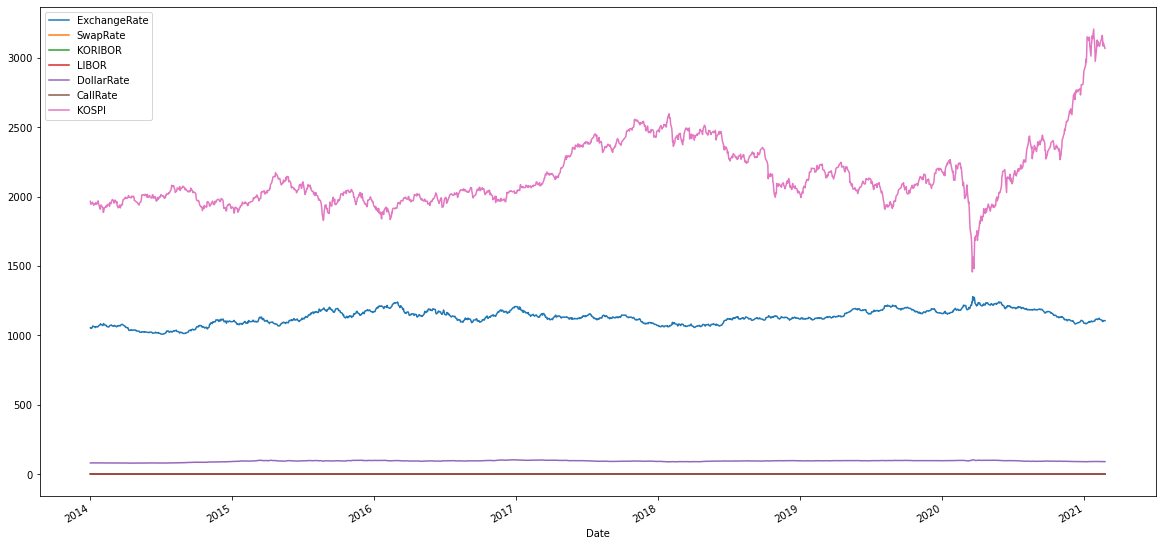

In [8]:
#시각화 해보자
df_intp.plot(x="Date",figsize = (20,10))
#표준화 필수의 느낌이 난다..

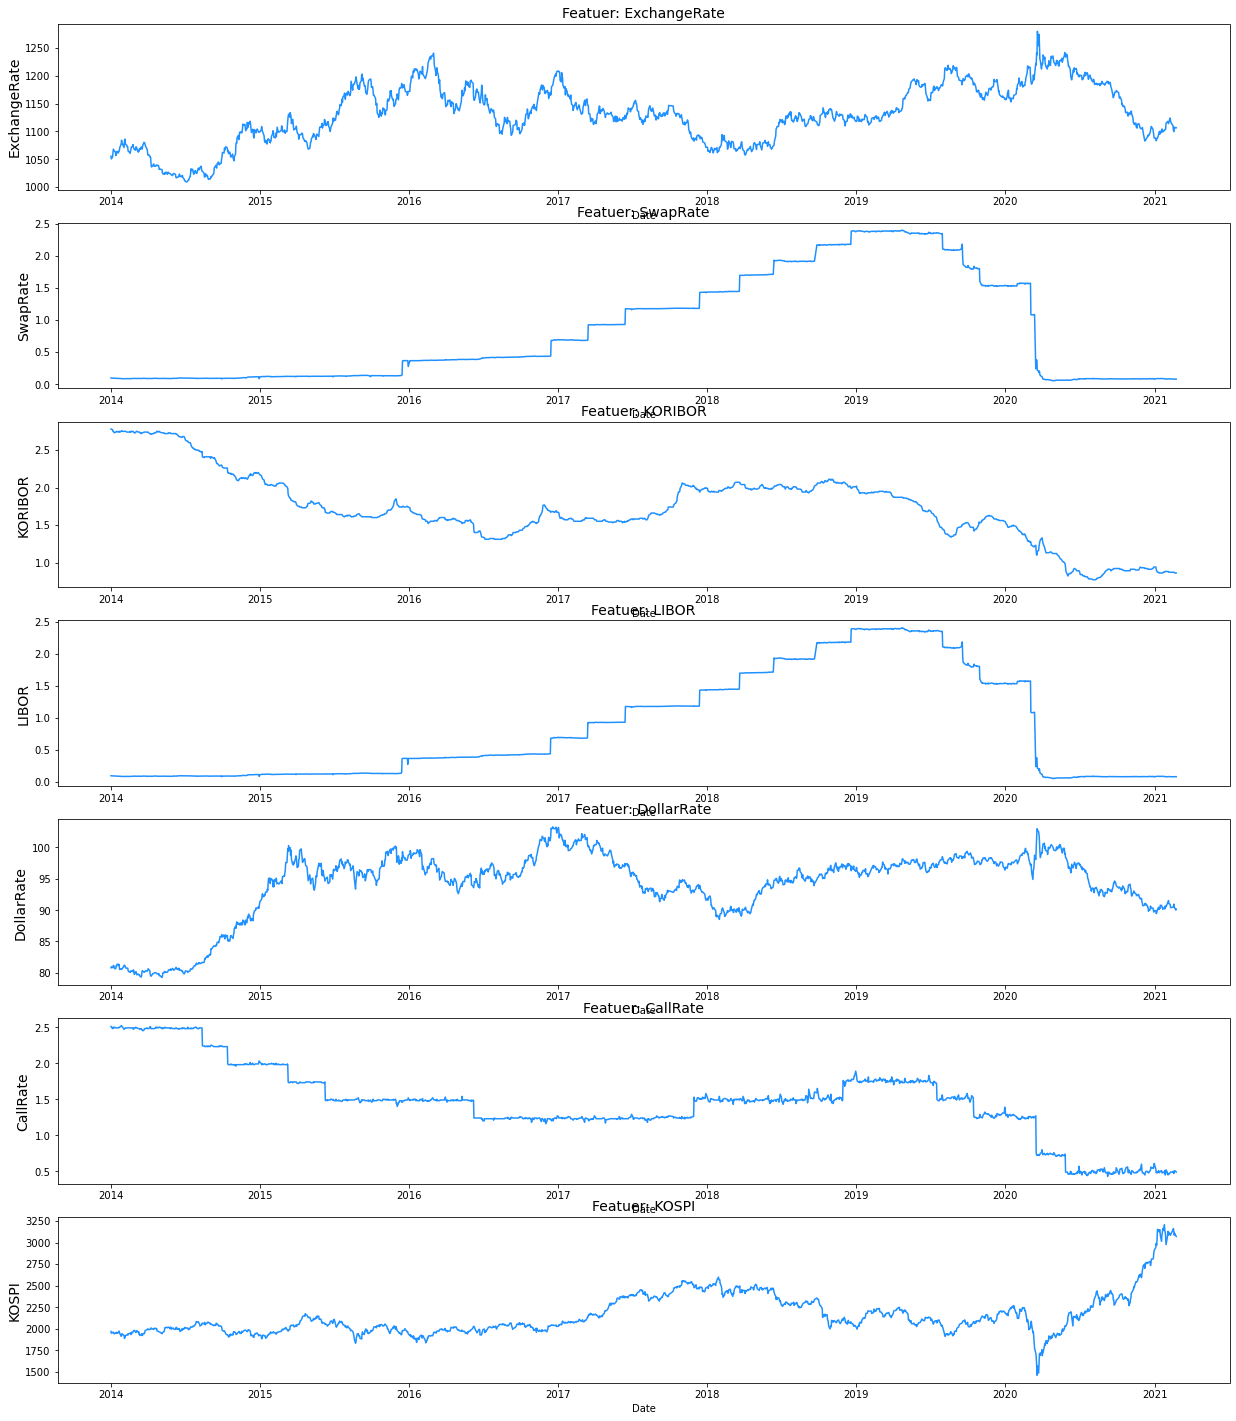

In [17]:
#개별 시각화
f, ax = plt.subplots(nrows = 7, ncols = 1, figsize = (21, 25))

for i, column in enumerate(df_intp.drop('Date', axis = 1).columns):
    sns.lineplot(x=df_intp['Date'], y = df_intp[column], ax = ax[i], color='dodgerblue')
    ax[i].set_title('Featuer: {}'.format(column), fontsize = 14)
    ax[i].set_ylabel(ylabel = column, fontsize = 14)
    
    #ax[i].set_xlim([Date(2014,1,1), Date(2021,2,24)])

## 정상성
- var을 사용하려면 차분을 해줘야한다
- 그 전에 adf테스트를 먼저하자

In [9]:
# df_intp.index = df_intp["Date"]
#df_intp.head() #날짜 열 인덱스로 고정, swaprate 리보랑 똑같기 때문에 하나 제거
df_date = df_intp.drop(["SwapRate"], axis = 1)
df_date.head()

,Date,ExchangeRate,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,2014-01-02,1055.3,2.78,0.0956,80.79,2.51,1967.19
1,2014-01-03,1050.4,2.78,0.0950,80.96,2.50,1946.14
2,2014-01-06,1054.1,2.77,0.0945,80.81,2.48,1953.28
3,2014-01-07,1062.2,2.75,0.0926,80.98,2.50,1959.44
4,2014-01-08,1067.9,2.75,0.0925,81.16,2.49,1958.96


## ADF 테스트
- 차분 전에 데이터가 정상성을 갖고있는지 단위근을 확인하는 검정 법
-귀무 : 자료에 단위근이 존재 (정상성 만족하지 않는다) 
-대립 : 시계열이 정상성을 만족한다 (하지만 어떻게 보이는지는 이 검정으로는 알 수 없다)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


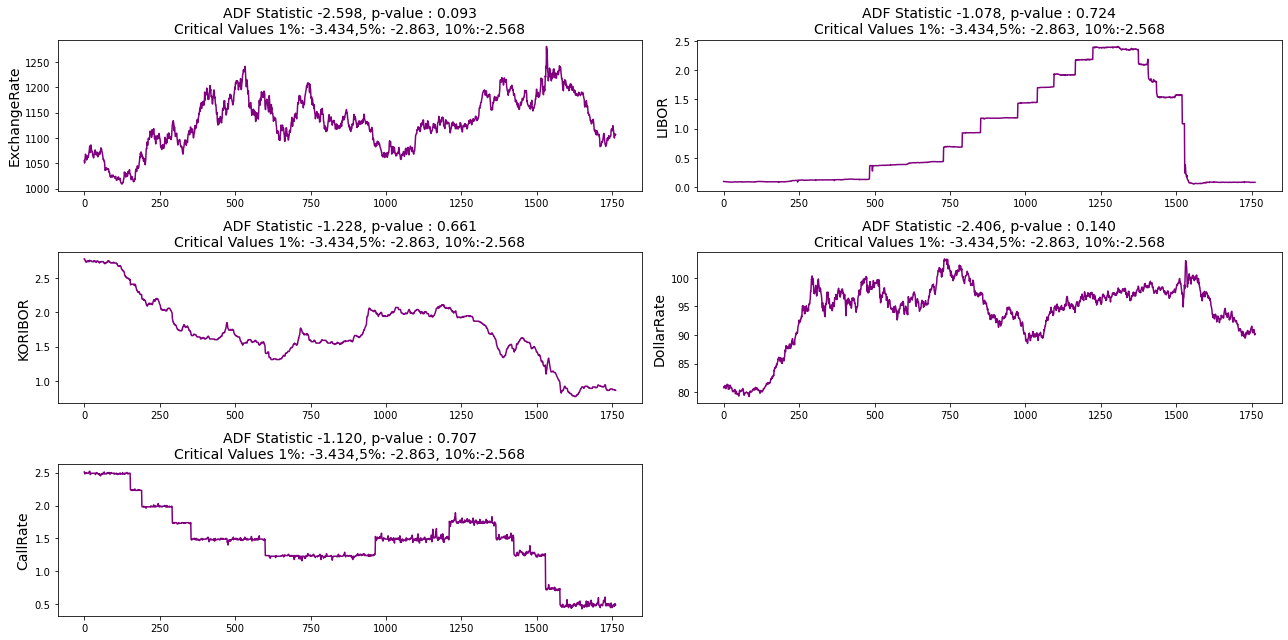

In [10]:
f, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (18,9)) #그래프 도화지 틀

#adf 비쥬얼 함수
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']
    
    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & ((adf_stat < crit_val_5)):
        linecolor = 'orange'
    elif (p_val < significance_level) & ((adf_stat < crit_val_10)):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x = df_date.index, y = series, ax=ax, color = linecolor)
    ax.set_title(f'ADF Statistic {adf_stat : 0.3f}, p-value : {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f},5%: {crit_val_5: 0.3f}, 10%:{crit_val_10:0.3f}', fontsize=14)
    #ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel = title, fontsize = 14)
    
visualize_adfuller_results(df_date['ExchangeRate'].values, "ExchangeRate",ax[0,0])
visualize_adfuller_results(df_date['KORIBOR'].values, "KORIBOR",ax[1,0])
visualize_adfuller_results(df_date['LIBOR'].values, "LIBOR",ax[0,1])
visualize_adfuller_results(df_date['DollarRate'].values, "DollarRate",ax[1,1])
visualize_adfuller_results(df_date['CallRate'].values, "CallRate",ax[2,0])
visualize_adfuller_results(df_date['KOSPI'].values, "KOSPI",ax[2,1])

f.delaxes(ax[2,1])
plt.tight_layout()
plt.show()

In [35]:
#싹다 단위근이 존재하면 정상성을 만족하지 않는 것 확인

## Differencing 
- 데이터가 단위근이 존재하니 변환을 해주도록 하자

In [100]:
#first order differencing
df_diff = df_date.diff()

In [101]:
df_diff.isna().sum() #차분할때 날짜 열을 빼자 바보같이
df_diff3 = df_diff.fillna(method = 'bfill')

In [102]:
df_diff3.head()

,Date,ExchangeRate,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,1 days,-4.9,0.00,-0.0006,0.17,-0.01,-21.05
1,1 days,-4.9,0.00,-0.0006,0.17,-0.01,-21.05
2,3 days,3.7,-0.01,-0.0005,-0.15,-0.02,7.14
3,1 days,8.1,-0.02,-0.0019,0.17,0.02,6.16
4,1 days,5.7,0.00,-0.0001,0.18,-0.01,-0.48


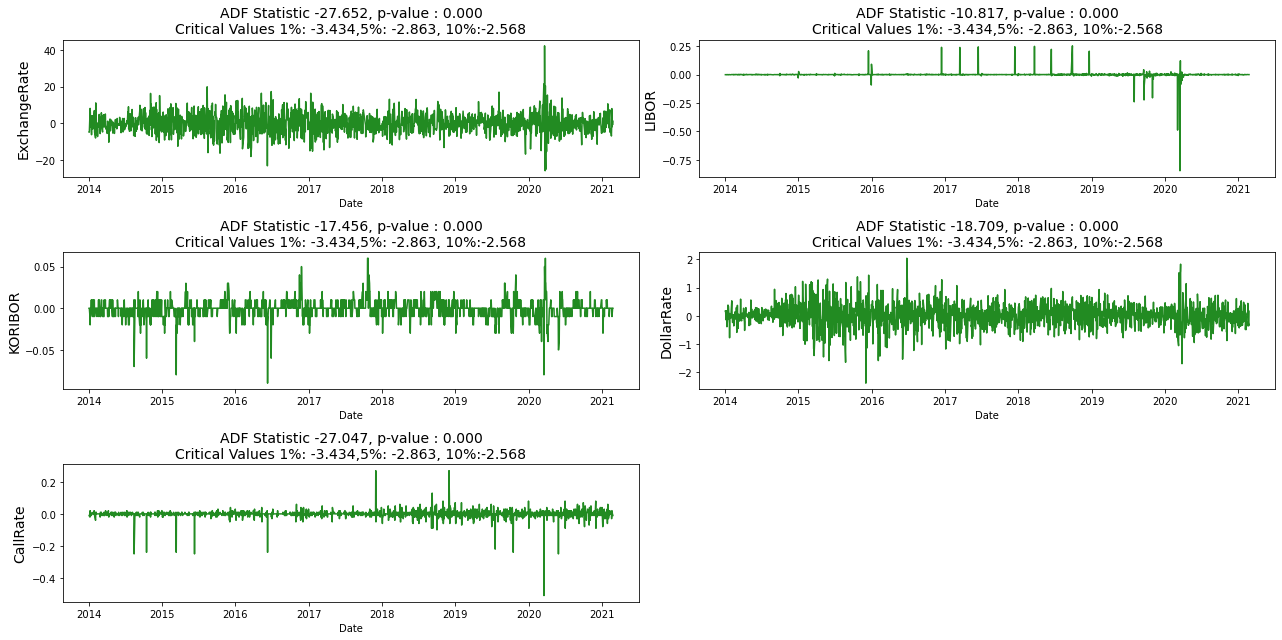

In [74]:
f, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (18,9)) #그래프 도화지 틀

#adf 비쥬얼 함수
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']
    
    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & ((adf_stat < crit_val_5)):
        linecolor = 'orange'
    elif (p_val < significance_level) & ((adf_stat < crit_val_10)):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x = df_date.index, y = series, ax=ax, color = linecolor)
    ax.set_title(f'ADF Statistic {adf_stat : 0.3f}, p-value : {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f},5%: {crit_val_5: 0.3f}, 10%:{crit_val_10:0.3f}', fontsize=14)
    #ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel = title, fontsize = 14)
    
visualize_adfuller_results(df_diff3['ExchangeRate'].values, "ExchangeRate",ax[0,0])
visualize_adfuller_results(df_diff3['KORIBOR'].values, "KORIBOR",ax[1,0])
visualize_adfuller_results(df_diff3['LIBOR'].values, "LIBOR",ax[0,1])
visualize_adfuller_results(df_diff3['DollarRate'].values, "DollarRate",ax[1,1])
visualize_adfuller_results(df_diff3['CallRate'].values, "CallRate",ax[2,0])
visualize_adfuller_results(df_diff3['KOSPI'].values, "KOSPI",ax[2,1])

f.delaxes(ax[2,1])
plt.tight_layout()
plt.show()

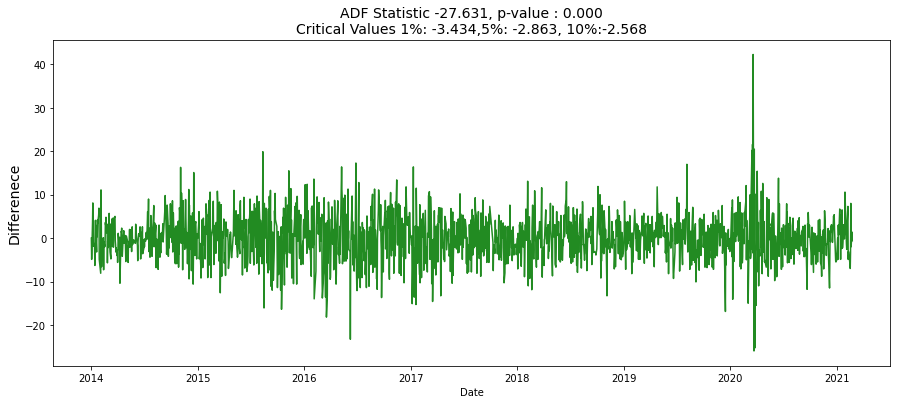

In [49]:
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,6))
visualize_adfuller_results(df['ExchangeRate_diff'], 'Differenece', ax)

## AutoCorrelation Analysis
- 차분 후 arima 모형을 적합시키는 다음 단계
- 자동상관 분석을 통해 AR, Ma가 필요한지 아닌지 여부를 결정
- 자기상관함수 (ACF), 편자기상관함수(PACF) 그림을 보면서 ar,ma항의 수를 임시 식별해보자

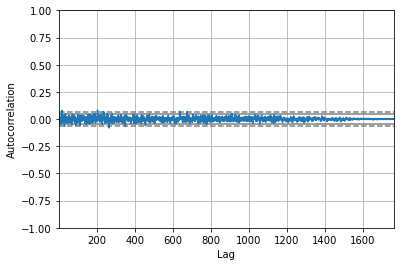

In [77]:
#자기상관 그래프
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_diff3["ExchangeRate"])
plt.show()

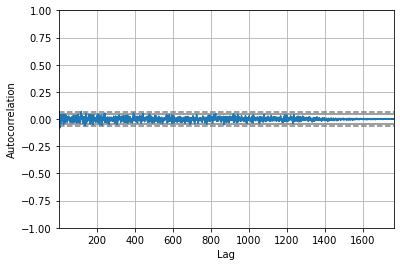

In [80]:
autocorrelation_plot(df_diff3["DollarRate"])
plt.show()

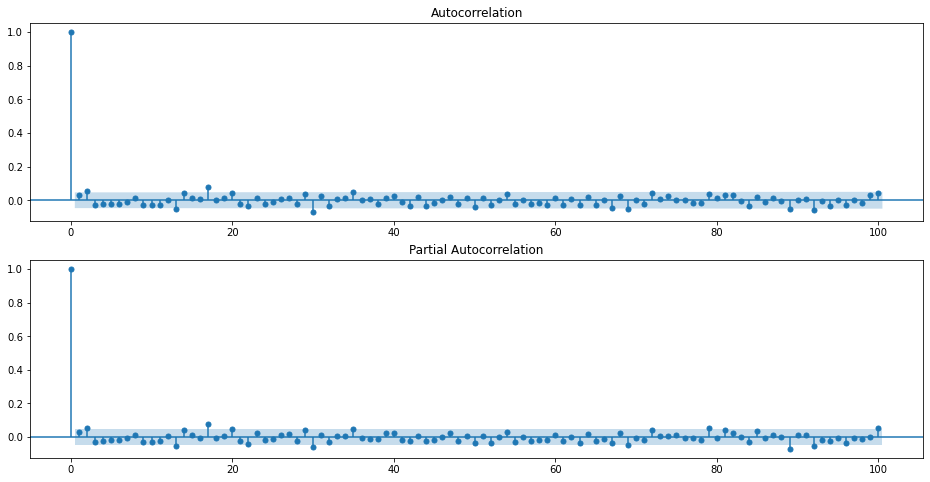

In [81]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df_diff3["ExchangeRate"], lags=100, ax=ax[0])
plot_pacf(df_diff3["ExchangeRate"], lags=100, ax=ax[1])

plt.show()

In [11]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS =3
X = df_date.index
y = df_date['ExchangeRate']

folds = TimeSeriesSplit(n_splits = N_SPLITS)

In [12]:
feature_columns = [
    'KORIBOR',
    'LIBOR',
    'DollarRate',
    'CallRate',
    'KOSPI'
]

target_column = ['ExchangeRate']

train_size = int(0.85 * len(df_date))

multivariate_df = df_date[['Date']+target_column +feature_columns].copy()
multivariate_df.columns = ['ds', 'y']+ feature_columns
multivariate_df.head()
train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5,6]]),pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5,6]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,2014-01-02,1055.3,2.78,0.0956,80.79,2.51,1967.19
1,2014-01-03,1050.4,2.78,0.0950,80.96,2.50,1946.14
2,2014-01-06,1054.1,2.77,0.0945,80.81,2.48,1953.28
3,2014-01-07,1062.2,2.75,0.0926,80.98,2.50,1959.44
4,2014-01-08,1067.9,2.75,0.0925,81.16,2.49,1958.96


In [ ]:
from fbprophet import Prophet

# Train the model
model = Prophet()
model.add_regressor('KORIBOR')
model.add_regressor('LIBOR')
model.add_regressor('DollarRate')
model.add_regressor('CallRate')
model.add_regressor('KOSPI')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NameError: name 'ᄆ' is not defined

- 최적의 모델을 찾기 위한 기준 AIC(Akaike's Information Criterion)를 모델 선택 기준으로 하자.

In [75]:
#aic 모델은 복잡한 모델은 불이익을 주곤한다.하지만 복잡한 모델일수록 성능이 우수할수 있음
# 그 변곡점을 찾아보자
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
    results = forecasting_model.fit(p)
    results_aic.append(results_aic)

In [1]:
# sns.set()
# plt.plot(list(np.arange(1,10,1)), results_aic)
# plt.xlabel("Order")
# plt.ylabel("AIC")
# plt.show()